In [2]:
import re
import numpy as np
import pandas as pd
import tabata as tbt
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline

import Projet_rectangularisation_vols as m2d 

%reload_ext autoreload
%autoreload 2


In [3]:
# Chargement des données.
datadir = "../Data/cleaned/"
final_file = datadir + "AFL1EB_cleaned_final.h5"
norm_file = datadir + "AFL1EB_normed_alt.h5"
ds = tbt.Opset(final_file)
ds

OPSET '../Data/cleaned/AFL1EB_cleaned_final.h5' de 47 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None

In [4]:
ds.plot()

In [5]:
# Ajout d'une référence normalisée à utiliser pour la transformation.

dsn1 = tbt.Opset(norm_file).clean()
for df in ds:
    alt = df["ALT[m]"]
    max_alt = np.max(alt)
    min_alt = np.min(alt)
    altn = (alt-min_alt)/(max_alt-min_alt)
    df["ALTN[-]"] = altn
    dsn1.put(df)
dsn1

OPSET '../Data/cleaned/AFL1EB_normed_alt.h5' de 47 signaux.
        position courante : sigpos  = 46
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None

In [6]:
df = dsn1.df
x = df["ALTN[-]"]
x.index

DatetimeIndex(['2013-02-20 02:58:00', '2013-02-20 02:58:01',
               '2013-02-20 02:58:02', '2013-02-20 02:58:03',
               '2013-02-20 02:58:04', '2013-02-20 02:58:05',
               '2013-02-20 02:58:06', '2013-02-20 02:58:07',
               '2013-02-20 02:58:08', '2013-02-20 02:58:09',
               ...
               '2013-02-20 05:33:17', '2013-02-20 05:33:18',
               '2013-02-20 05:33:19', '2013-02-20 05:33:20',
               '2013-02-20 05:33:21', '2013-02-20 05:33:22',
               '2013-02-20 05:33:23', '2013-02-20 05:33:24',
               '2013-02-20 05:33:25', '2013-02-20 05:33:26'],
              dtype='datetime64[ns]', name='record_51', length=9327, freq='s')

# Création d'une série d'instants de changement de phase par vol.

* t1 : fin du roulage/début de montée

* t2 : début de croisière

* t3 : fin de croisière

* t4 : début de descente/freinage

* txm : point médian du sommet du vo

In [7]:
import numpy as np

def compute_points(df):
    """Détection automatique des phases caractéristiques d’un vol sur le signal d’altitude (ALT[m])"""

    y = df['ALT[m]'].values
    n = len(y)
    t = np.arange(0, n)

    # Point t1 : fin roulage, début montée
    t1 = np.max(np.argwhere((y < y[0] + 10) & (t < n / 3)))

    # Point t4 : début descente finale
    t4 = np.min(np.argwhere((y < y[-1] + 10) & (t > 2 * n / 3)))

    # Dérivée + lissage
    dy = np.append(np.diff(y), 0)
    k = 3
    dyc = np.convolve(dy, np.ones(2 * k + 1) / (2 * k + 1), mode='same')

    # Altitude max
    mx = np.max(y)
    tx = np.argwhere(y == mx)
    txm = (tx[0] + tx[-1]) / 2  # milieu du plateau haut

    # t2 : fin montée
    t2 = np.min(np.argwhere((y > mx - mx / 10) & (dyc < 2.5) & (t > t1) & (t < txm)))

    # t3 : début descente
    t3 = np.max(np.argwhere((y > mx - mx / 10) & (dyc > -2.5) & (t < t4) & (t > txm)))

    return t1, t2, t3, t4


interactive(children=(IntSlider(value=23, description='record', max=47), Output()), _dom_classes=('widget-inte…

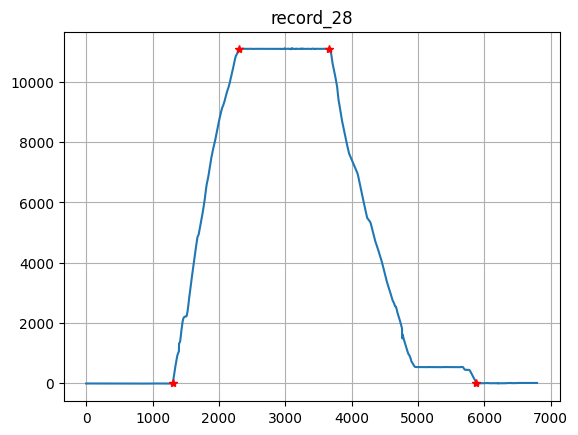

In [8]:
fig, ax = plt.subplots()

@widgets.interact(record=(0,len(ds)))
def update_points(record):
    #[l.remove() for l in ax.lines]
    df = ds[record]
    y = df['ALT[m]'].values
    t1,t2,t3,t4 = m2d.compute_points(df)
    print(record)
    print(t1,t2,t3,t4)

    # Affichage
    ax.cla()
    ax.plot(y)
    ax.plot([t1, t2, t3, t4],[y[t1],y[t2],y[t3], y[t4]],'*r')
    ax.grid()
    ax.set_title(df.index.name)
    display(fig)

In [9]:
L = []
for i,df in enumerate(ds):
    t1,t2,t3,t4 = m2d.compute_points(df)
    
    L.append({'record' : i, 'points' : np.array([t1,t2,t3,t4])})

In [10]:
P = m2d.compute_all_sizes(ds)

In [11]:
NL = P.max(axis=0)


# Empilation des altitudes dans un tableau

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

N_total = 200  # total de points (ex: 50 points/phase × 4 phases)

# calcul des points de découpe pour tous les vols
P = []
for df in ds:
    t1, t2, t3, t4 = compute_points(df) 
    P.append([t1, t2 - t1, t3 - t2, t4 - t3, len(df) - t4])
P = np.array(P)
NL = P.max(axis=0).astype(int)  # nombre de points par phase

In [13]:
# interpolation phase par phase
R = []
for df in ds:
    y = df['ALT[m]'].values
    index = df.index
    t1, t2, t3, t4 = compute_points(df)
    bounds = [0, t1, t2, t3, t4, len(df)-1]
    yn = (y - np.min(y)) / (np.max(y) - np.min(y))  # normalisation entre 0 et 1
    y_interp = []

    for i in range(len(bounds) - 1):
        i0, i1 = bounds[i], bounds[i+1]
        t0 = index[i0].value
        t1 = index[i1].value
        t_new = pd.to_datetime(np.linspace(t0, t1, NL[i]))
        y_new = np.interp(t_new, index[i0:i1], yn[i0:i1])
        y_interp.extend(y_new if i == 0 else y_new[1:])  # évite doublons

    R.append(y_interp)

R = pd.DataFrame(data=np.vstack(R).T)  # format : (points, vols)

In [14]:
R.tail()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
18707,0.00517,0.002928,0.00272,0.002302,0.003808,0.002985,0.003536,0.002848,0.003276,0.00262,...,0.003126,0.00296,0.002795,0.002051,0.002545,0.002872,0.000961,0.002437,0.003086,0.002734
18708,0.00517,0.002928,0.00272,0.002249,0.003748,0.002985,0.003585,0.002848,0.003276,0.00262,...,0.003090,0.00296,0.002795,0.002051,0.002545,0.002872,0.001049,0.002437,0.003086,0.002734
18709,0.00517,0.002928,0.00272,0.002202,0.003705,0.002985,0.003611,0.002848,0.003276,0.00262,...,0.003160,0.00296,0.002795,0.002051,0.002545,0.002872,0.001023,0.002437,0.003086,0.002734
18710,0.00517,0.002928,0.00272,0.002202,0.003705,0.002985,0.003611,0.002848,0.003276,0.00262,...,0.003187,0.00296,0.002795,0.002051,0.002545,0.002872,0.000961,0.002437,0.003086,0.002734
18711,0.00517,0.002928,0.00272,0.002202,0.003705,0.002985,0.003611,0.002848,0.003276,0.00262,...,0.003187,0.00296,0.002795,0.002051,0.002545,0.002872,0.000961,0.002437,0.003086,0.002734


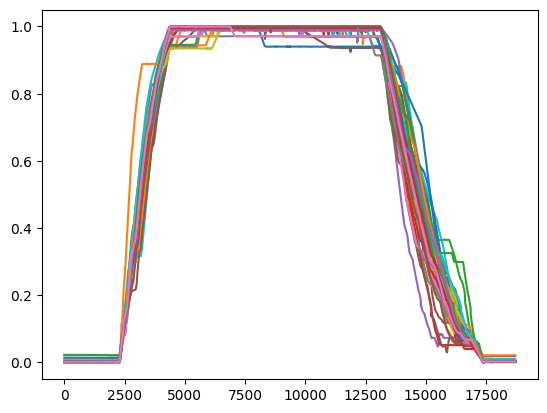

In [15]:
plt.plot(R) ;

In [16]:
# interpolation sans découpe
R_triv = []
for df in ds:
    y = df['ALT[m]'].values
    yn = (y - np.min(y)) / (np.max(y) - np.min(y))
    t0, t1 = df.index[0].value, df.index[-1].value
    t_new = pd.to_datetime(np.linspace(t0, t1, R.shape[0]))
    y_new = np.interp(t_new, df.index, yn)
    R_triv.append(y_new)
R_triv = pd.DataFrame(data=np.vstack(R_triv).T)

In [17]:
R_triv.tail()  

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
18707,0.00517,0.002928,0.00272,0.002244,0.003711,0.002985,0.003551,0.002848,0.003276,0.00262,...,0.003079,0.00296,0.002795,0.002051,0.002545,0.002872,0.001055,0.002437,0.003086,0.002734
18708,0.00517,0.002928,0.00272,0.002206,0.003705,0.002985,0.003596,0.002848,0.003276,0.00262,...,0.003135,0.00296,0.002795,0.002051,0.002545,0.002872,0.001041,0.002437,0.003086,0.002734
18709,0.00517,0.002928,0.00272,0.002202,0.003705,0.002985,0.003641,0.002848,0.003276,0.00262,...,0.003187,0.00296,0.002795,0.002051,0.002545,0.002872,0.000975,0.002437,0.003086,0.002735
18710,0.00517,0.002928,0.00272,0.002202,0.003705,0.002985,0.003687,0.002848,0.003276,0.00262,...,0.003187,0.00296,0.002795,0.002051,0.002545,0.002872,0.000961,0.002437,0.003086,0.002792
18711,0.00517,0.002928,0.00272,0.002202,0.003705,0.002985,0.003732,0.002848,0.003276,0.00262,...,0.003187,0.00296,0.002795,0.002051,0.002545,0.002872,0.000961,0.002437,0.003086,0.002848


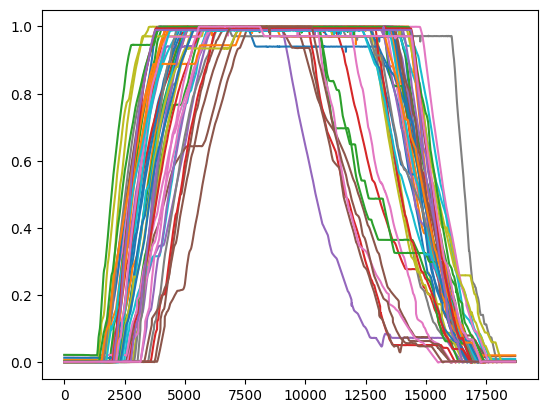

In [18]:
plt.plot(R_triv) ;

interactive(children=(IntSlider(value=0, description='Vol', max=46), IntSlider(value=1, description='Densité x…

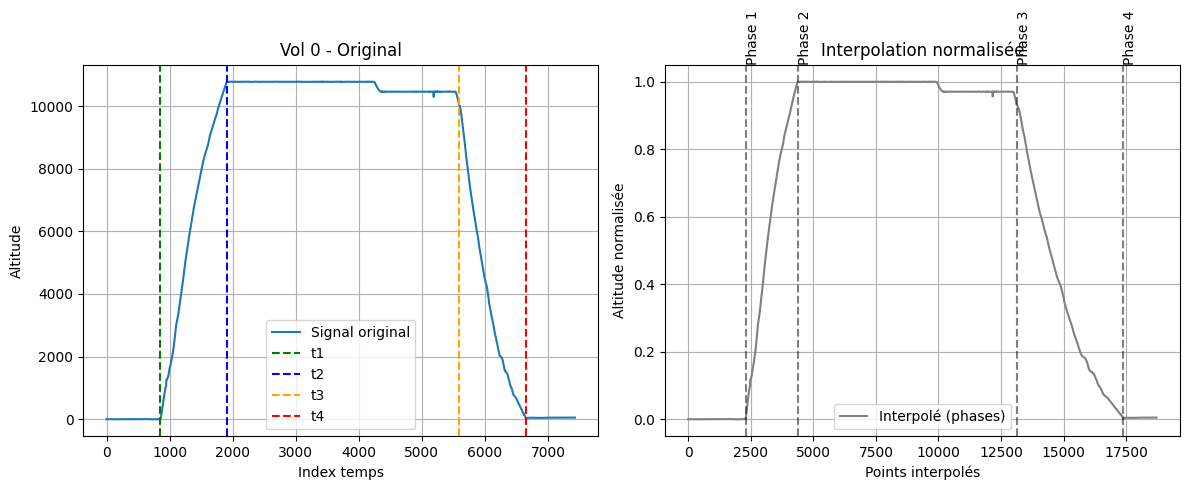

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

# === Initialisation ===
ds = tbt.Opset(final_file)

# Étape 1 : calcul des points t1–t4 pour tous les vols
P = []
for df in ds:
    t1, t2, t3, t4 = compute_points(df)
    P.append([t1, t2 - t1, t3 - t2, t4 - t3, len(df) - t4])
P = np.array(P)
NL_base = P.max(axis=0).astype(int)  # points de base par phase

# === Visualisation interactive ===

fig, (ax1, ax2) = plt.subplots(1, 2)

@widgets.interact(
    record=widgets.IntSlider(min=0, max=len(ds)-1, step=1, value=0, description='Vol'),
    densite=widgets.IntSlider(min=1, max=5, step=1, value=1, description='Densité x')
)
def update_visualisation(record=0, densite=1):
    ax1.cla()
    ax2.cla()
    
    df = ds[record]
    y = df['ALT[m]'].values
    index = df.index
    t1, t2, t3, t4 = compute_points(df)
    bounds = [0, t1, t2, t3, t4, len(df)-1]

    # Courbe originale
    ax1.plot(y, label='Signal original')
    for t, color, label in zip([t1, t2, t3, t4], ['g', 'b', 'orange', 'r'], ['t1', 't2', 't3', 't4']):
        ax1.axvline(x=t, color=color, linestyle='--', label=label)
    ax1.set_title(f"Vol {record} - Original")
    ax1.set_xlabel("Index temps")
    ax1.set_ylabel("Altitude")
    ax1.legend()
    ax1.grid()

    # Interpolation
    yn = (y - np.min(y)) / (np.max(y) - np.min(y))  # normalisation
    y_interp = []
    NL = (NL_base * densite).astype(int)
    
    for i in range(len(bounds) - 1):
        i0, i1 = bounds[i], bounds[i+1]
        t0 = index[i0].value
        t1_ = index[i1].value
        t_new = pd.to_datetime(np.linspace(t0, t1_, NL[i]))
        y_new = np.interp(t_new, index[i0:i1], yn[i0:i1])
        y_interp.extend(y_new if i == 0 else y_new[1:])  # éviter doublons

    ax2.plot(y_interp, color='gray', label="Interpolé (phases)")
    cum_lengths = np.cumsum(NL)
    for i, x in enumerate(cum_lengths[:-1]):
        ax2.axvline(x=x, linestyle='--', color='k', alpha=0.5)
        ax2.text(x, 1.05, f"Phase {i+1}", rotation=90, verticalalignment='bottom')

    ax2.set_title("Interpolation normalisée")
    ax2.set_xlabel("Points interpolés")
    ax2.set_ylabel("Altitude normalisée")
    ax2.grid()
    ax2.legend()

    fig.tight_layout()
    display(fig)


In [20]:
import numpy as np
import pandas as pd

def erreur_reconstruction_par_phase(df):
    """
    Calcule l'erreur de reconstruction pour chaque phase (ligne du DataFrame).
    """
    return df.std(axis=1)

# On applique aux deux méthodes
errors_phase = erreur_reconstruction_par_phase(R)
errors_triv = erreur_reconstruction_par_phase(R_triv)

# Créer un DataFrame pour comparer phase par phase
comparaison = pd.DataFrame({
    "Erreur (Phases détectées)": errors_phase,
    "Erreur (Méthode triviale)": errors_triv
})

# Afficher les résultats
print("\nComparaison des erreurs de reconstruction par phase :")
print(comparaison.round(6))

# Facultatif : afficher un résumé statistique
print("\nRésumé statistique :")
print(comparaison.describe().round(6))



Comparaison des erreurs de reconstruction par phase :
       Erreur (Phases détectées)  Erreur (Méthode triviale)
0                       0.004509                   0.004509
1                       0.004509                   0.004509
2                       0.004509                   0.004509
3                       0.004509                   0.004510
4                       0.004512                   0.004511
...                          ...                        ...
18707                   0.003749                   0.003749
18708                   0.003748                   0.003748
18709                   0.003748                   0.003749
18710                   0.003749                   0.003749
18711                   0.003749                   0.003749

[18712 rows x 2 columns]

Résumé statistique :
       Erreur (Phases détectées)  Erreur (Méthode triviale)
count               18712.000000               18712.000000
mean                    0.024810                   0.1276

In [22]:
# Courbe médiane (ligne par ligne)
median_curve = R.median(axis=1)

# Distance à la courbe médiane (erreur moyenne par vol)
sync_error = R.apply(lambda col: np.mean((col - median_curve)**2), axis=0)

print("Erreur moyenne de synchronisation (méthode phases):", sync_error.mean())

# Pour la méthode triviale
median_curve_triv = R_triv.median(axis=1)
sync_error_triv = R_triv.apply(lambda col: np.mean((col - median_curve_triv)**2), axis=0)

print("Erreur moyenne de synchronisation (méthode triviale):", sync_error_triv.mean())


Erreur moyenne de synchronisation (méthode phases): 0.0013078453514589238
Erreur moyenne de synchronisation (méthode triviale): 0.03109898561269768


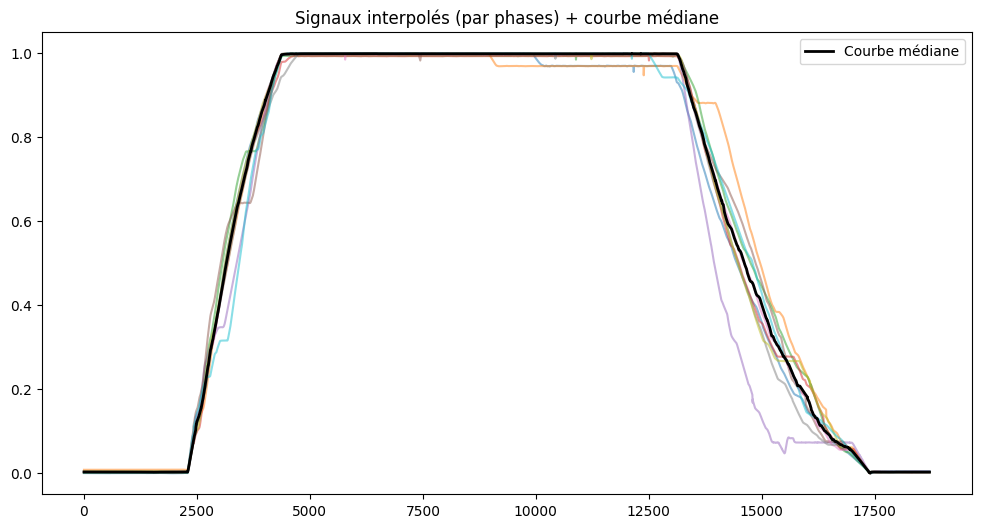

In [23]:
plt.figure(figsize=(12, 6))
for col in R.columns[:10]:  # jusqu'à 10 signaux
    plt.plot(R[col], alpha=0.5)
plt.plot(median_curve, color='black', label='Courbe médiane', linewidth=2)
plt.title("Signaux interpolés (par phases) + courbe médiane")
plt.legend()
plt.show()

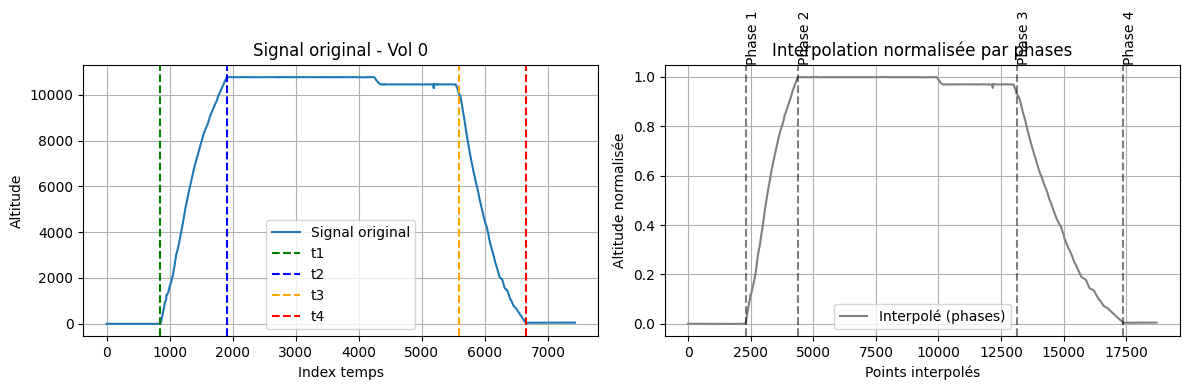

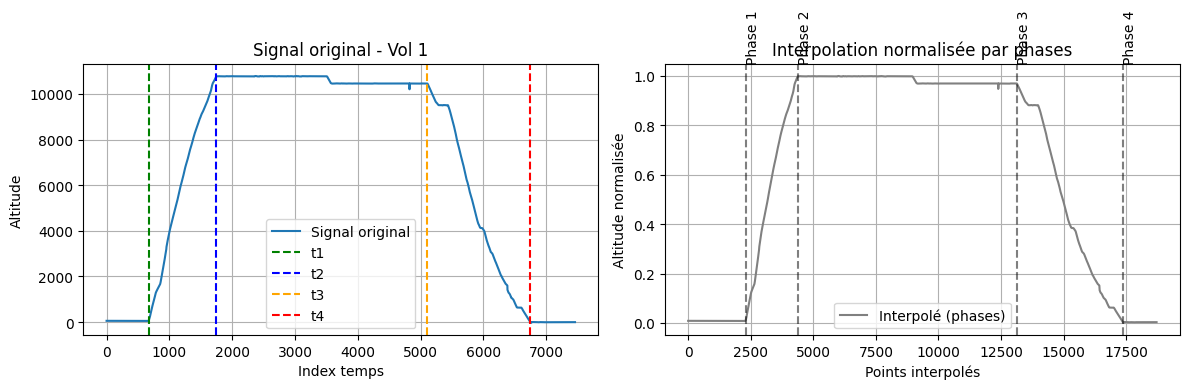

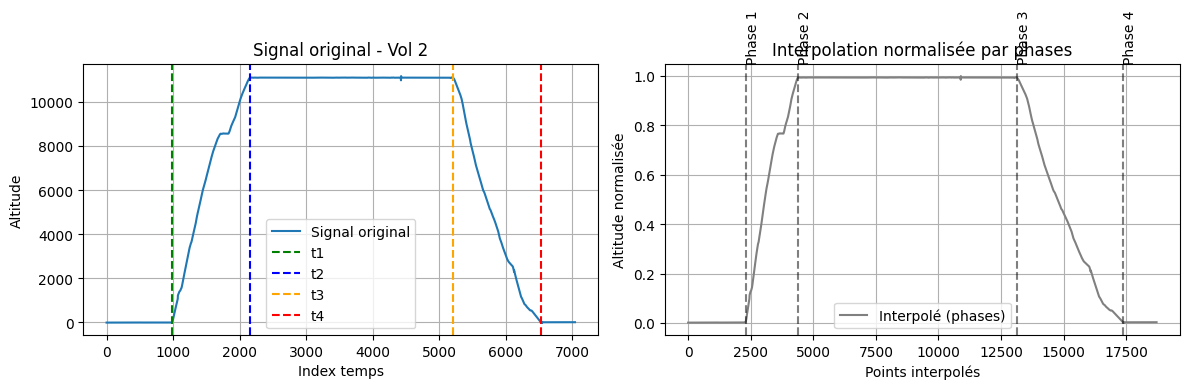

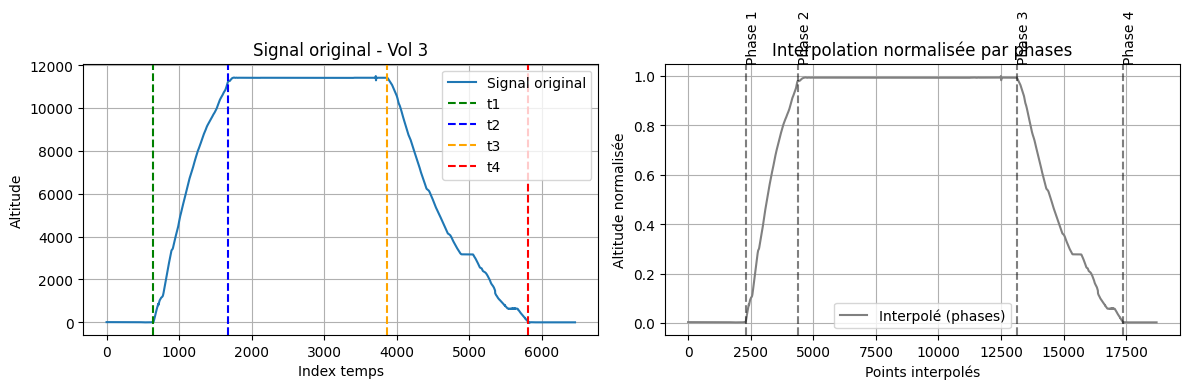

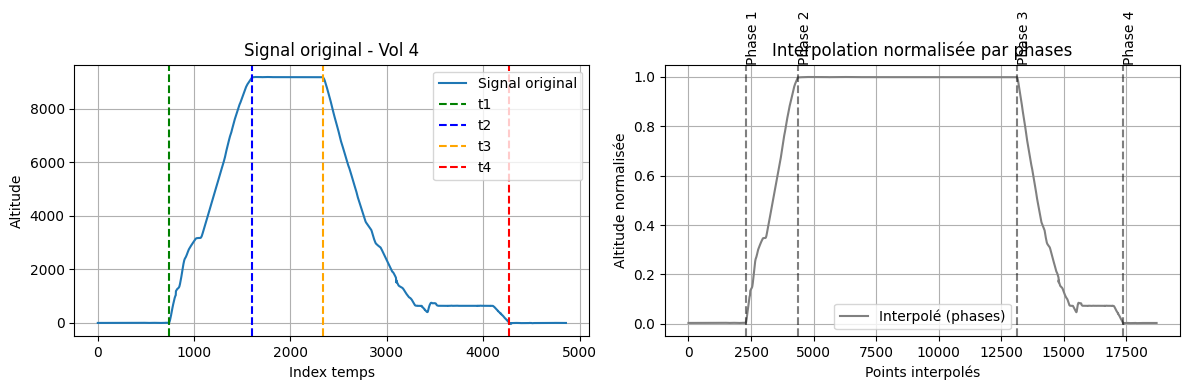

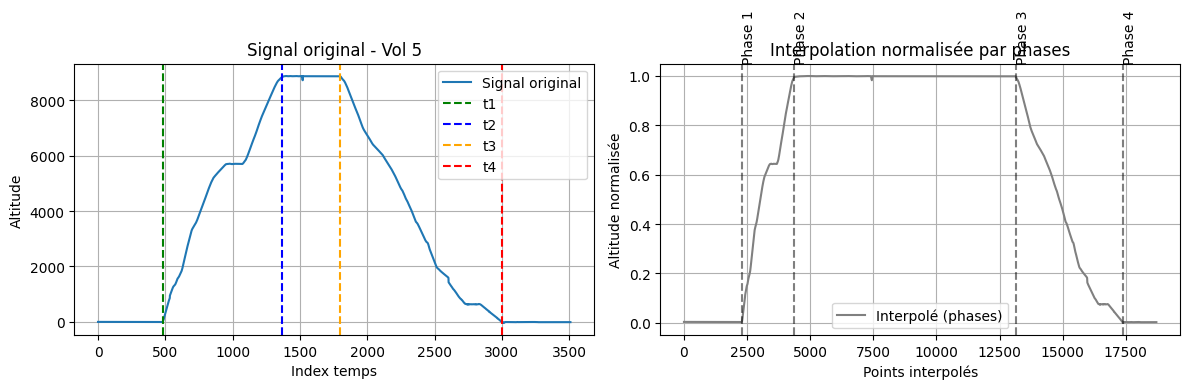

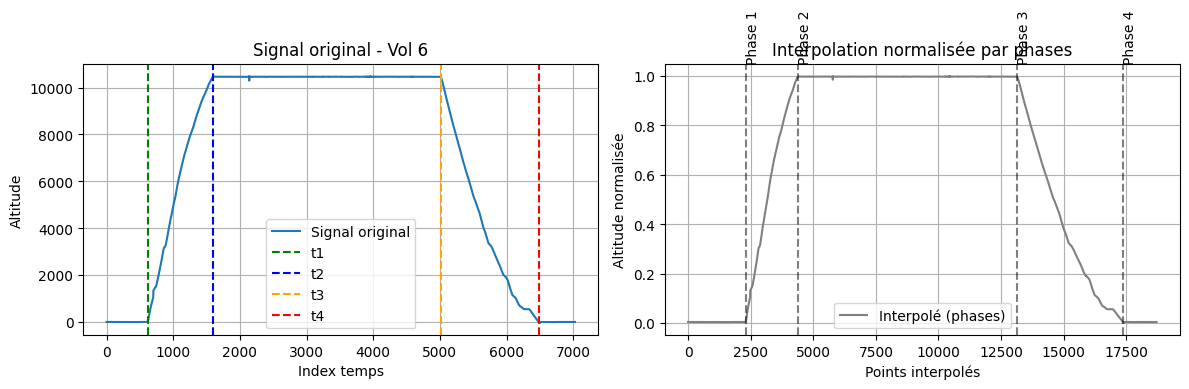

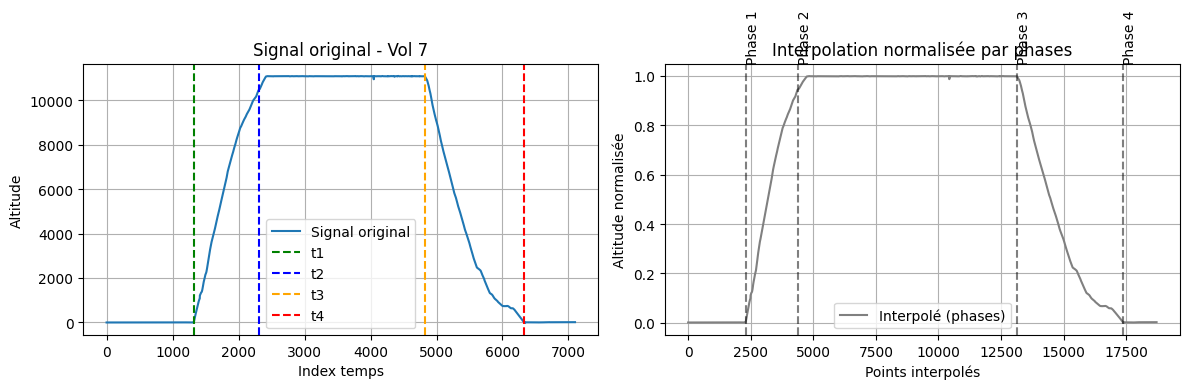

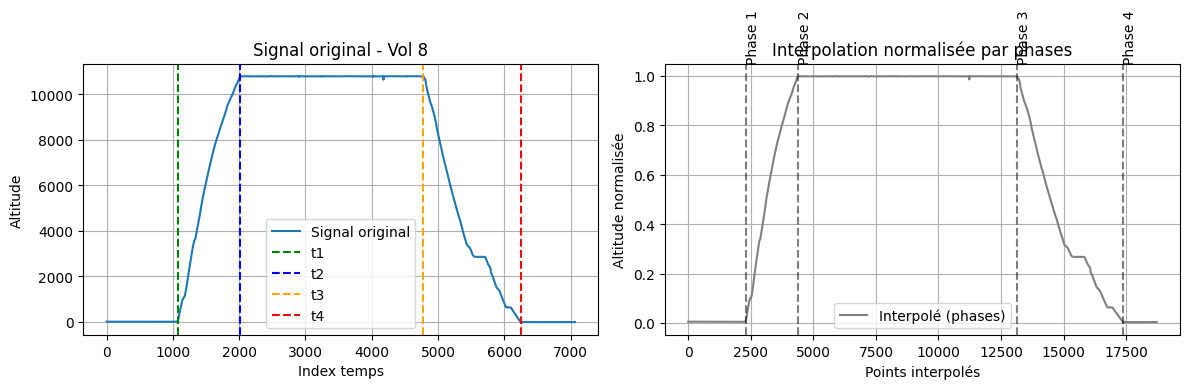

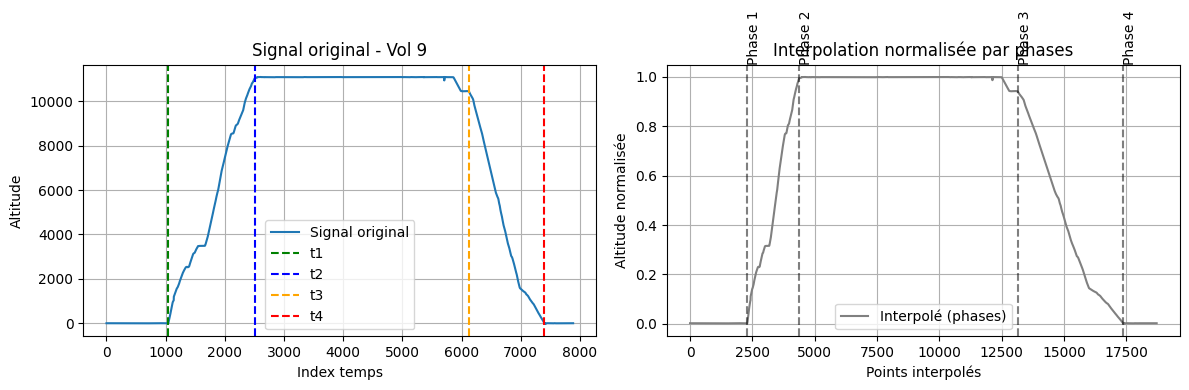

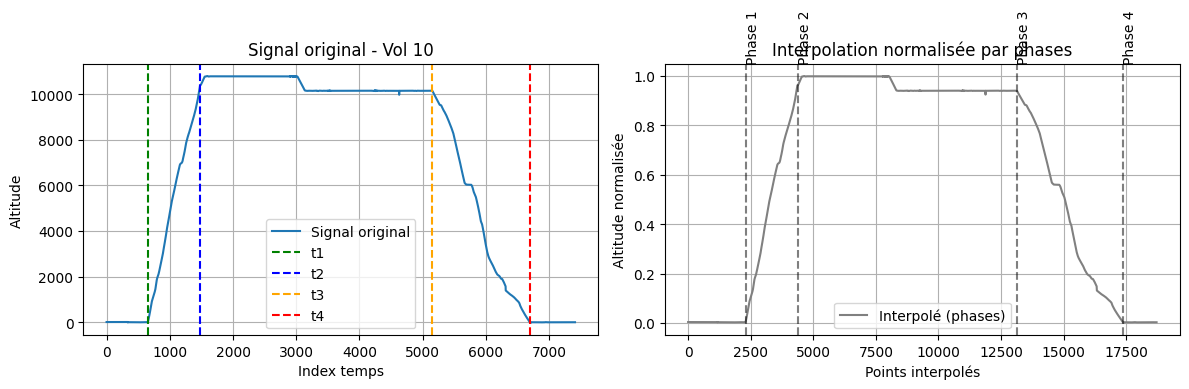

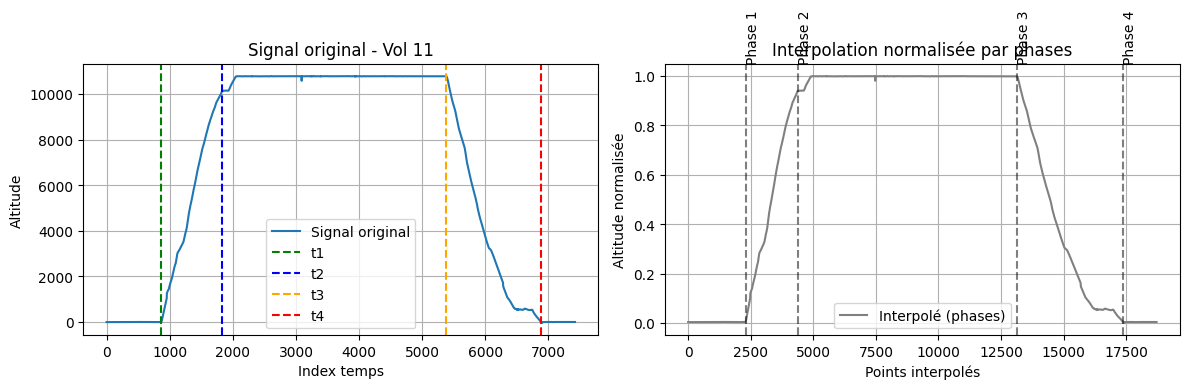

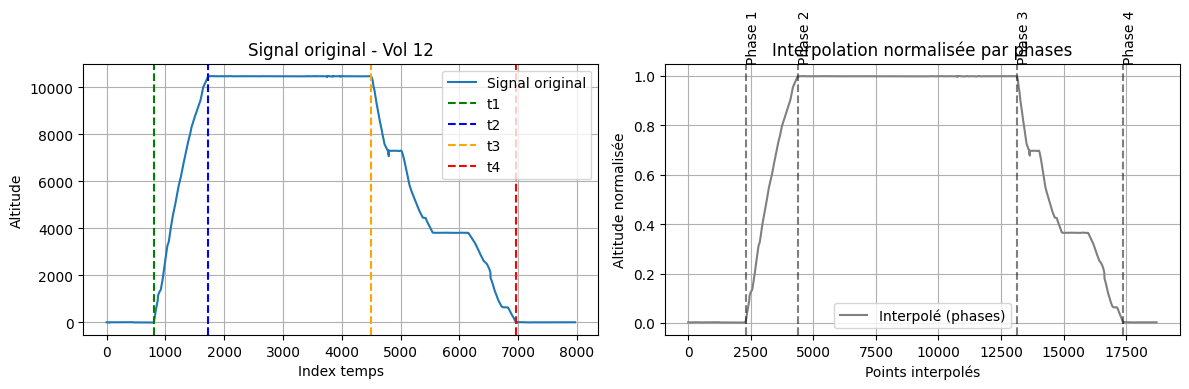

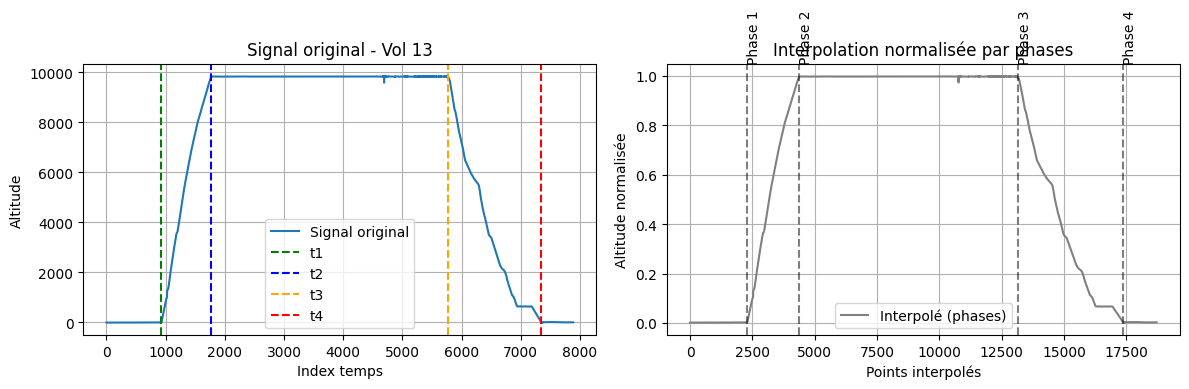

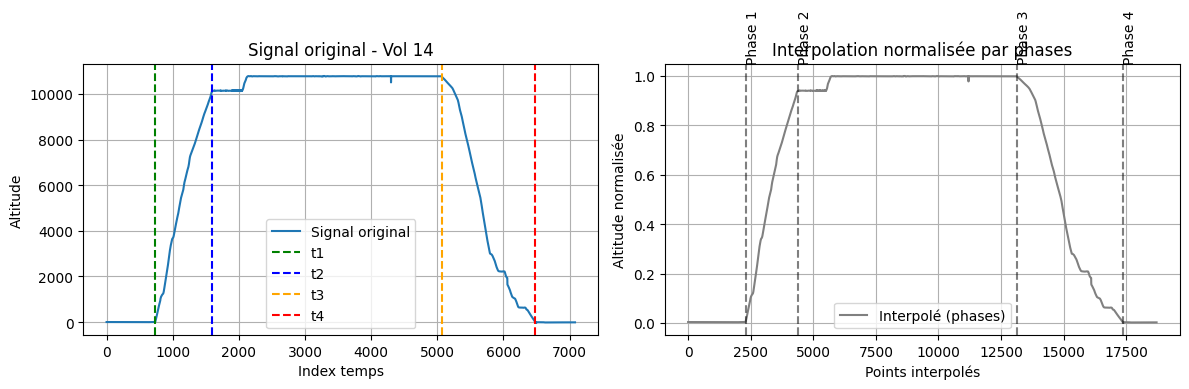

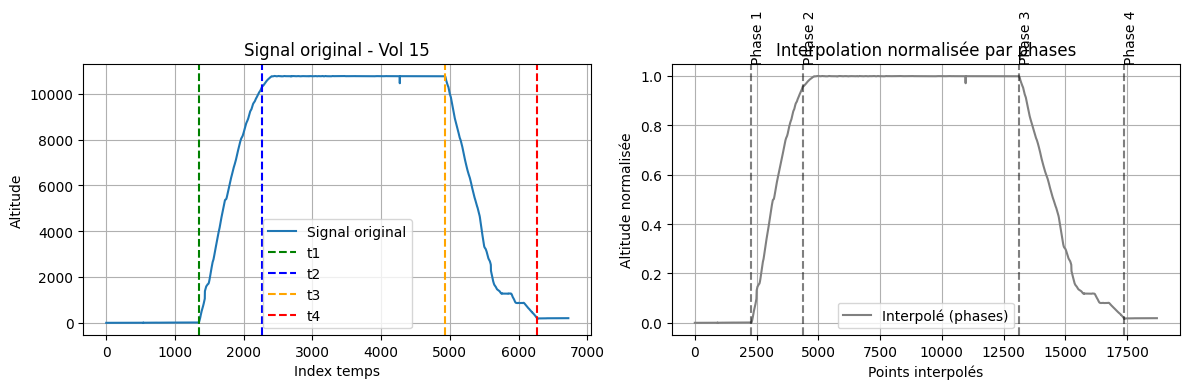

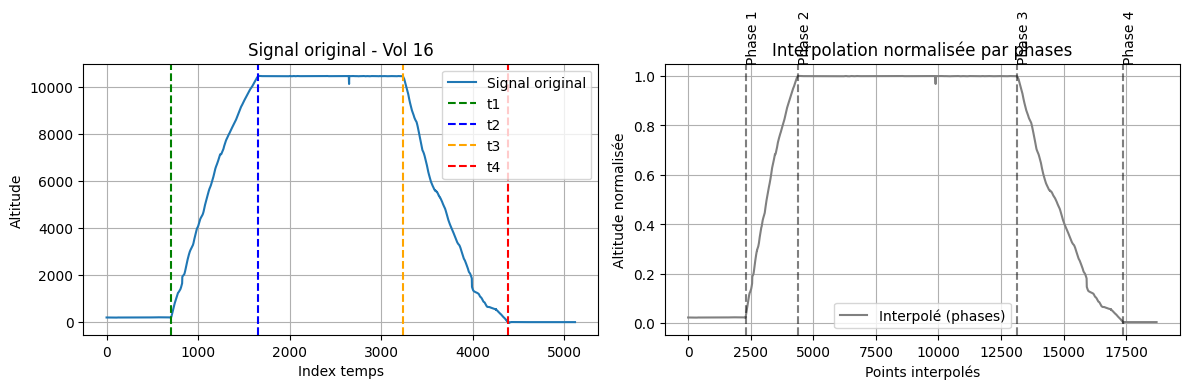

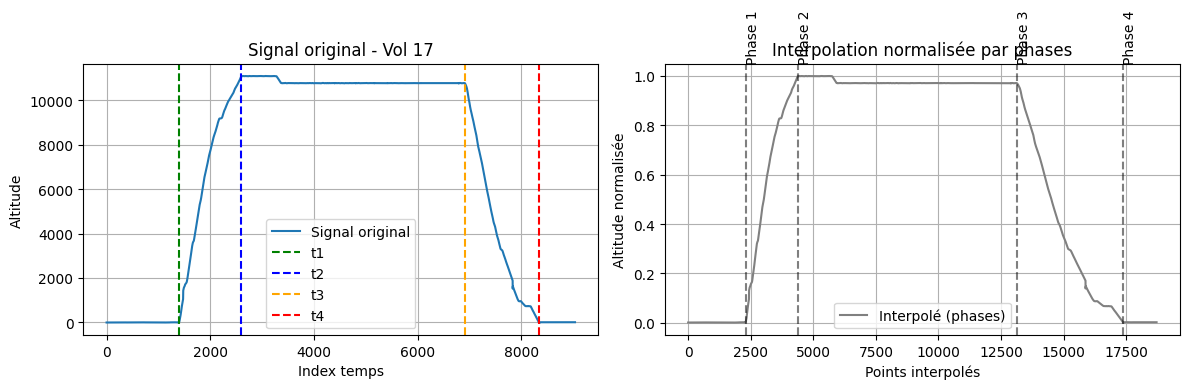

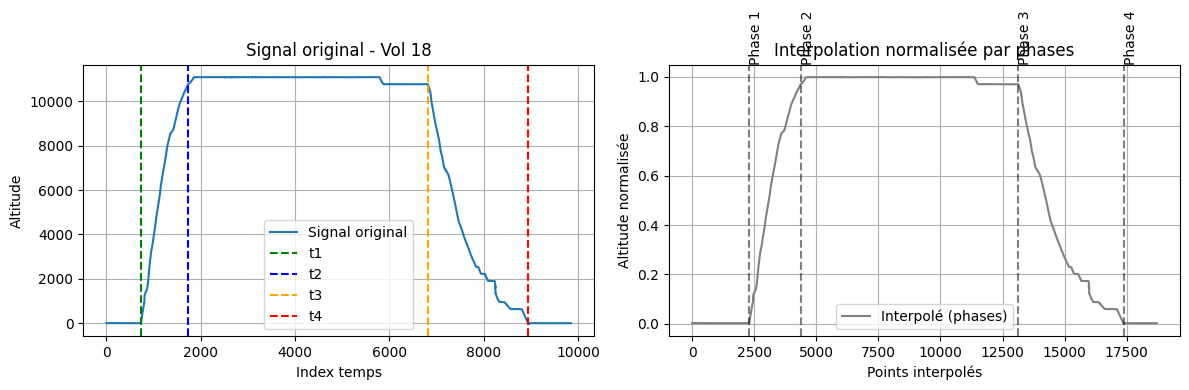

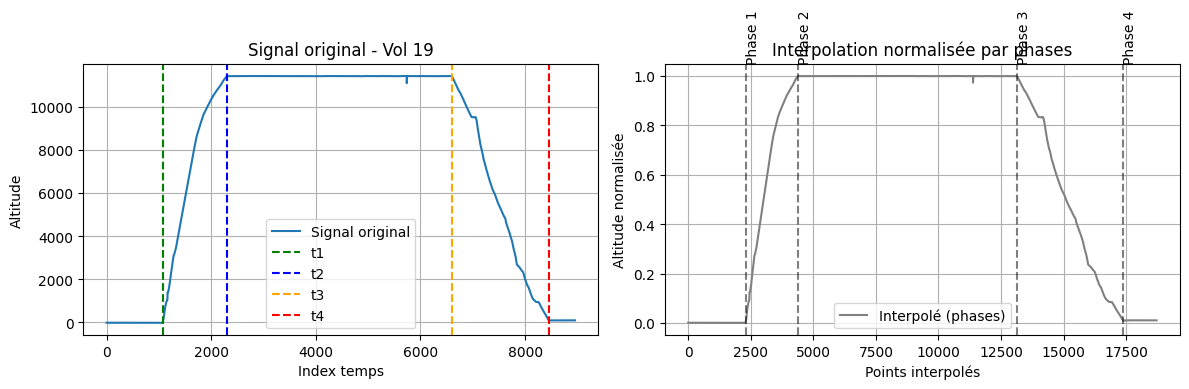

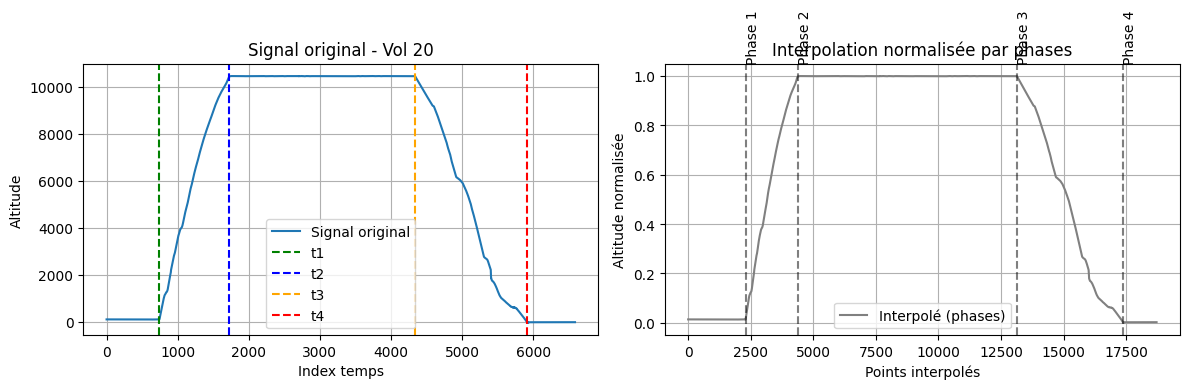

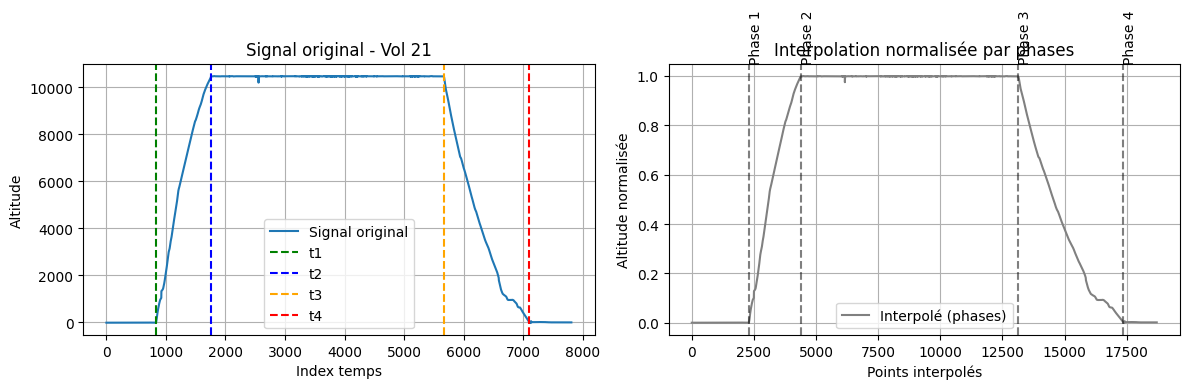

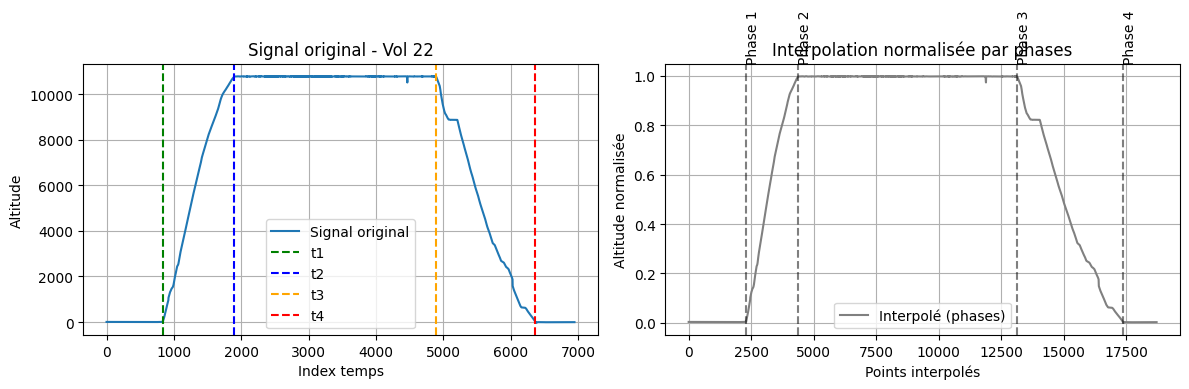

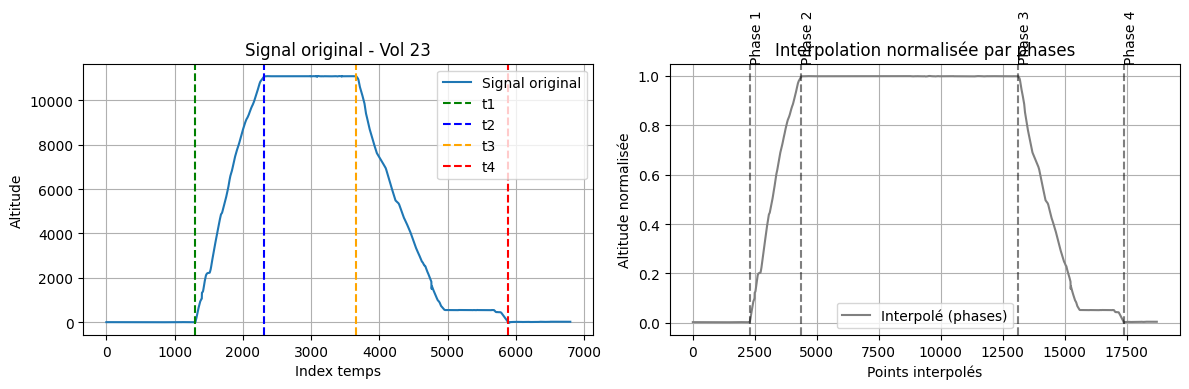

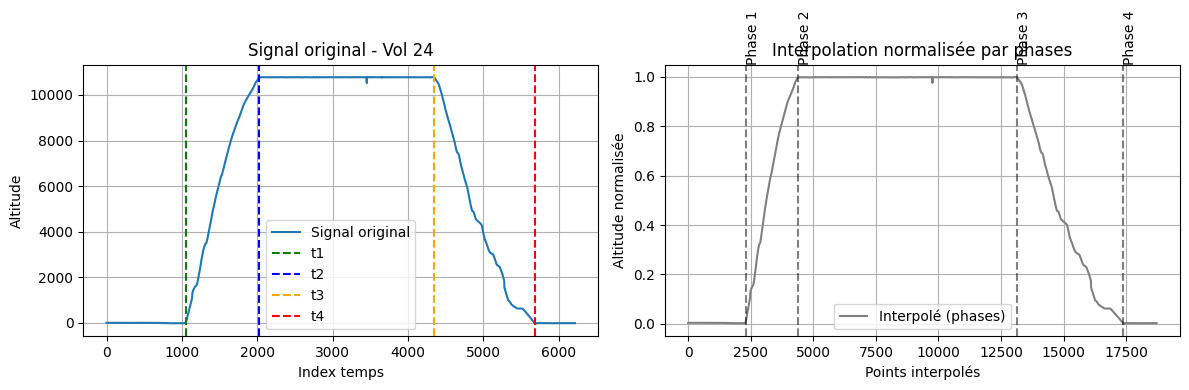

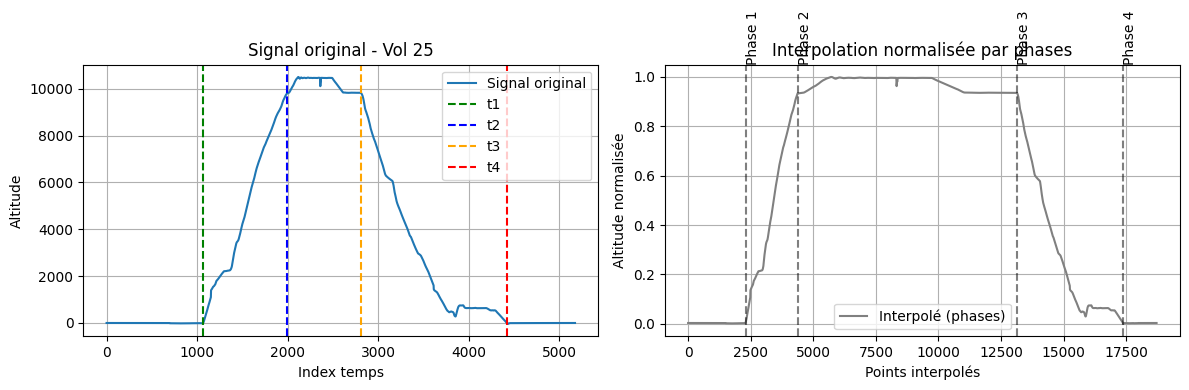

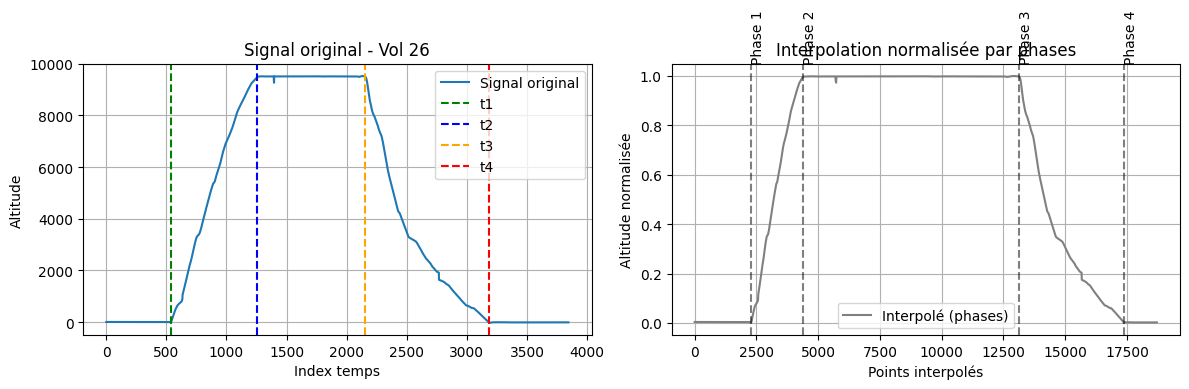

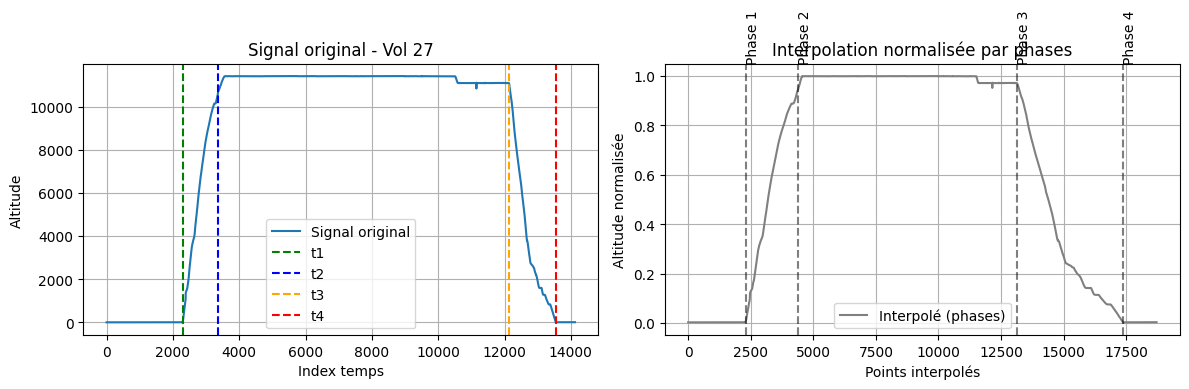

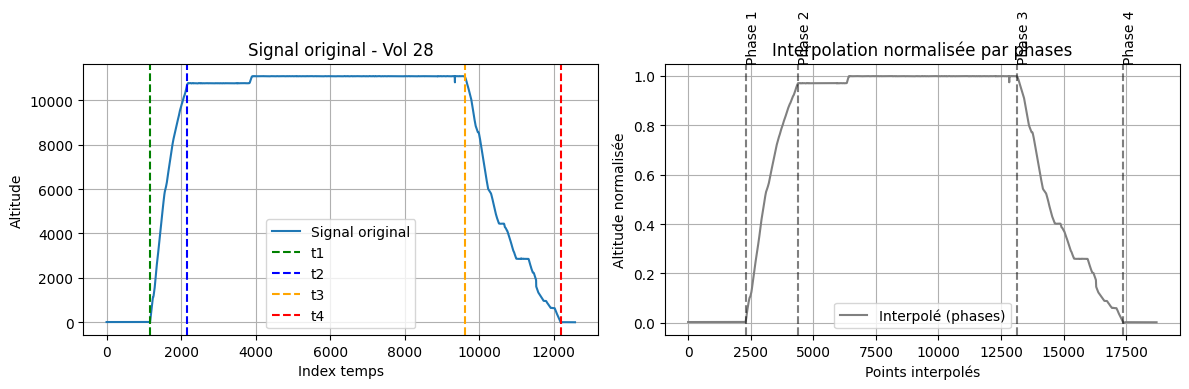

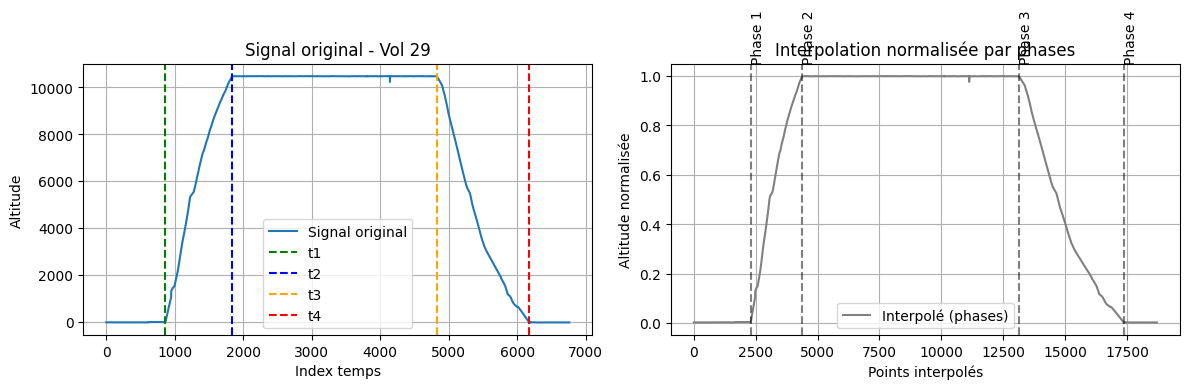

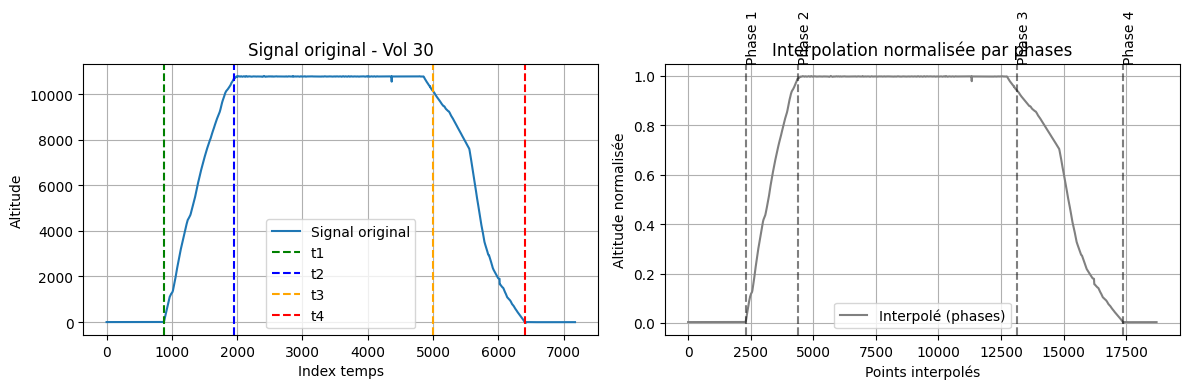

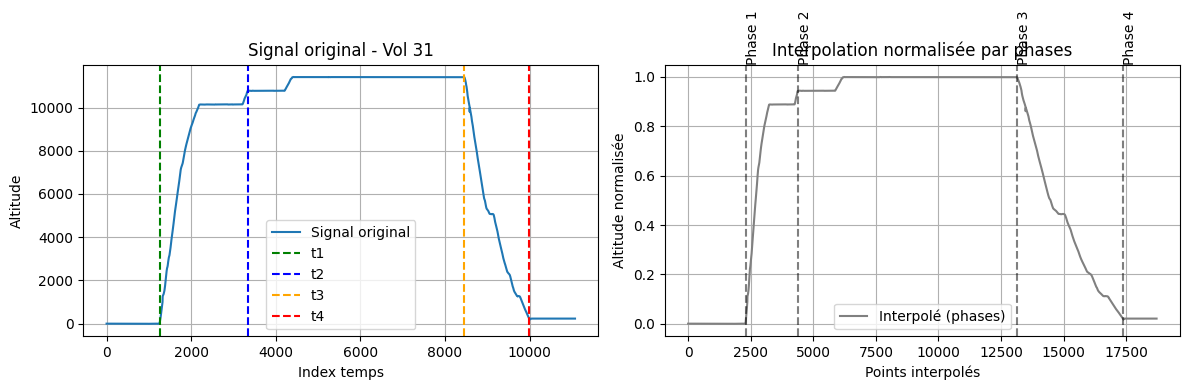

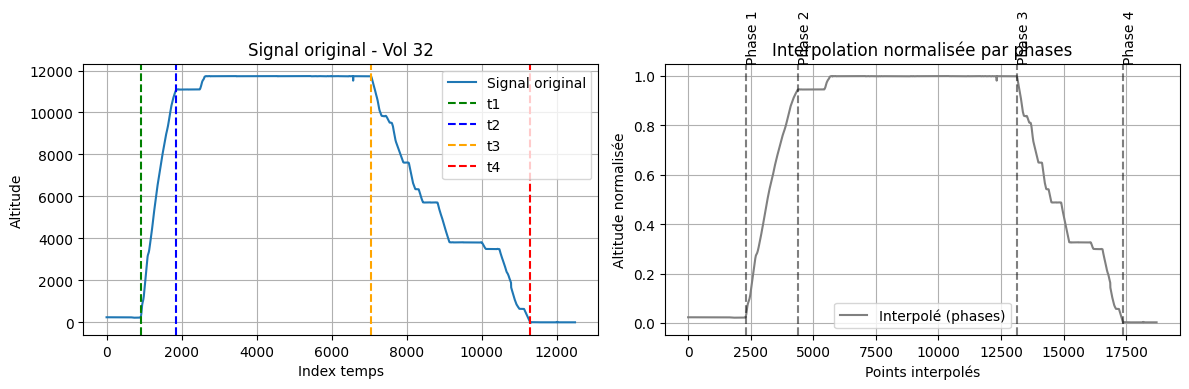

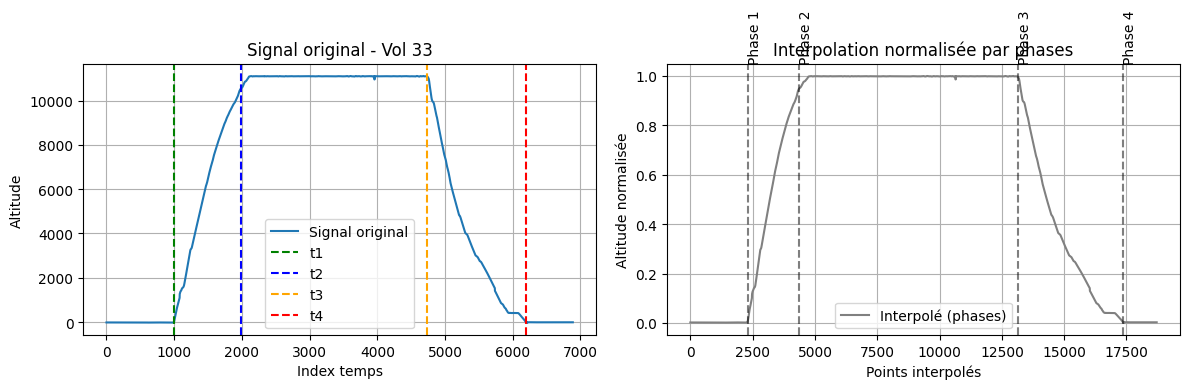

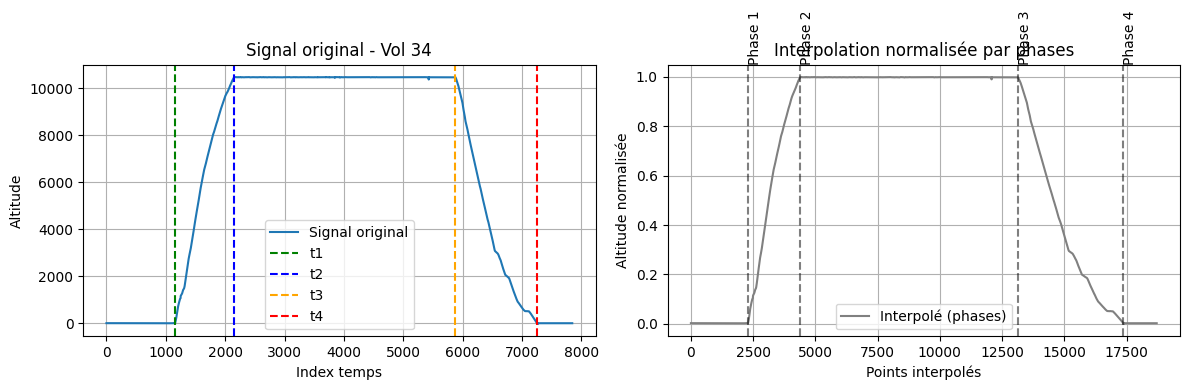

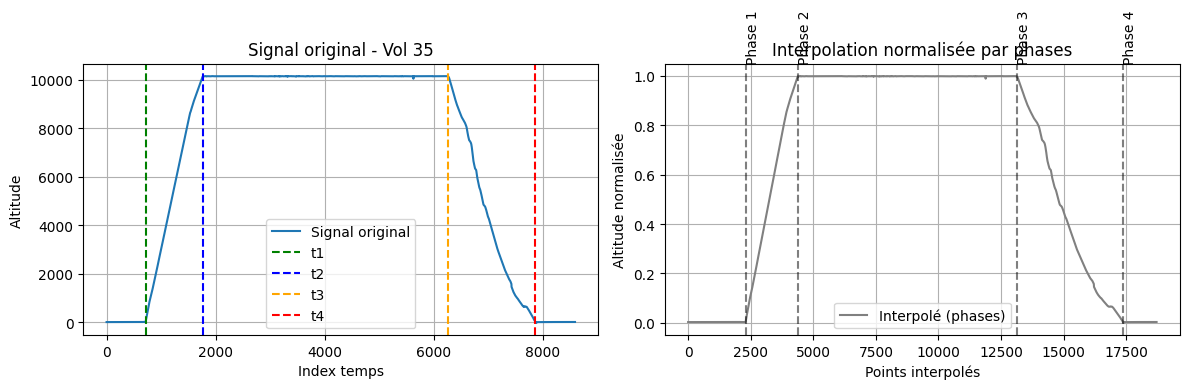

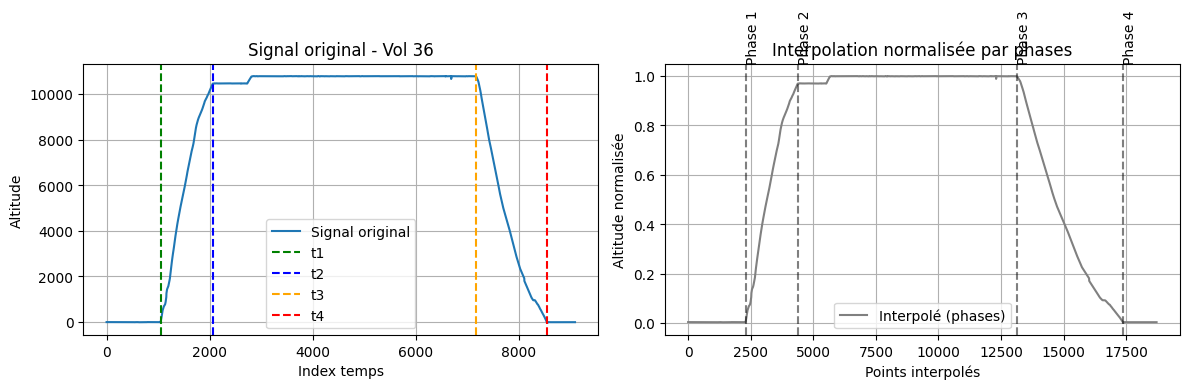

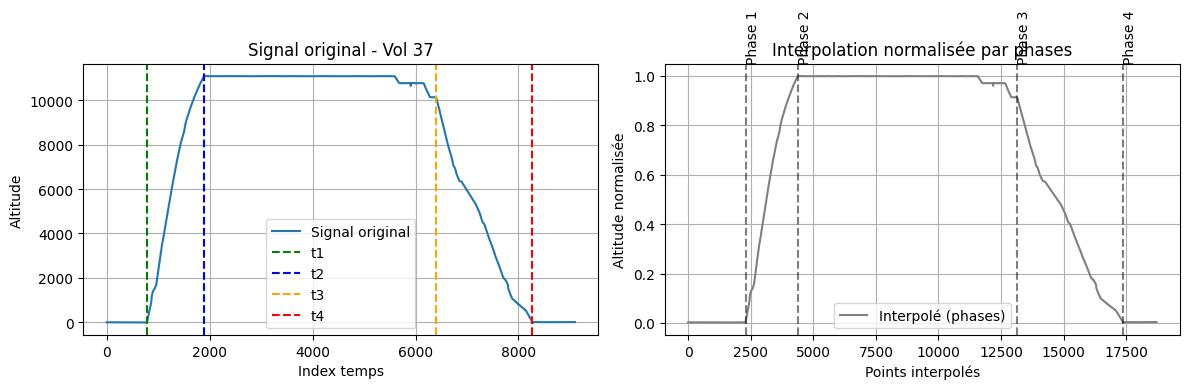

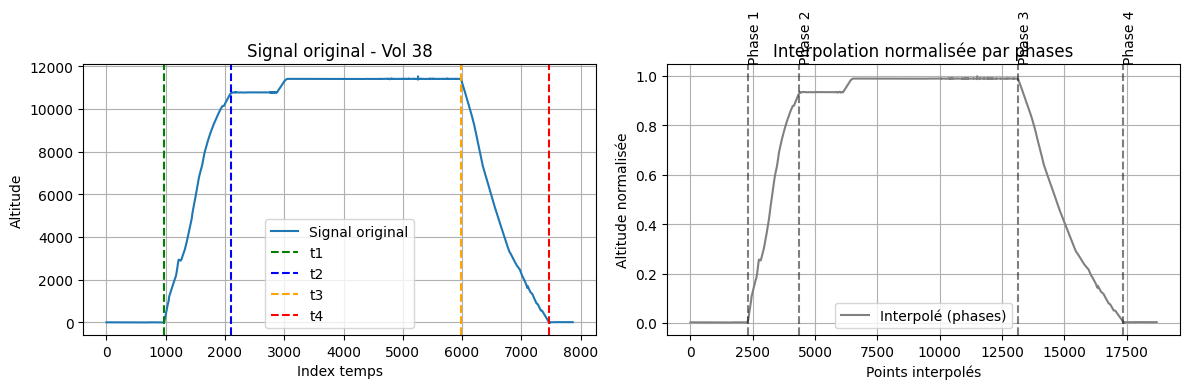

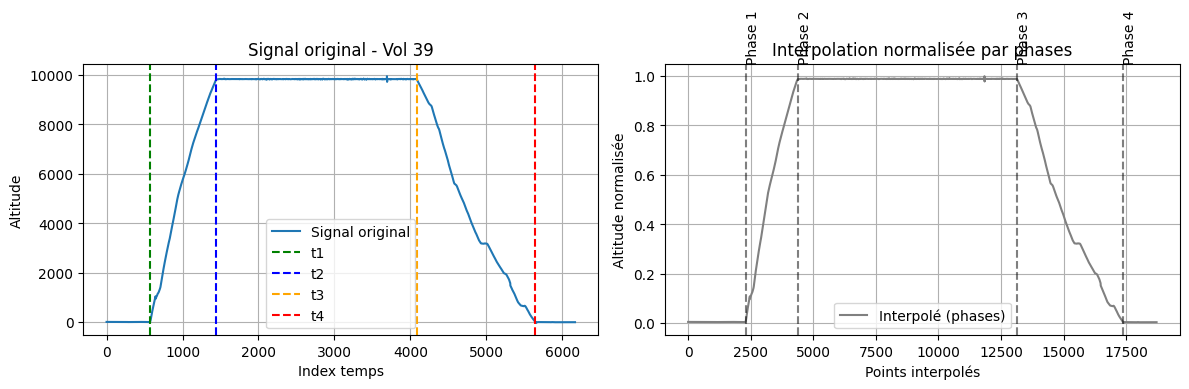

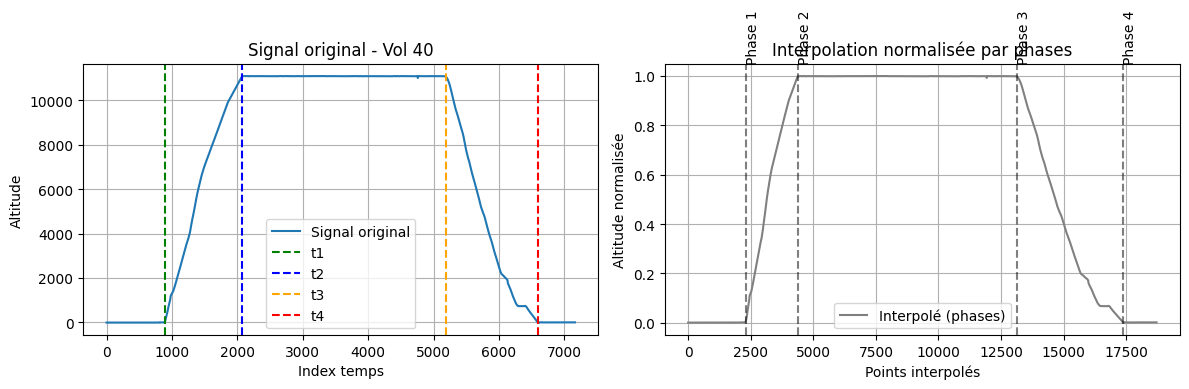

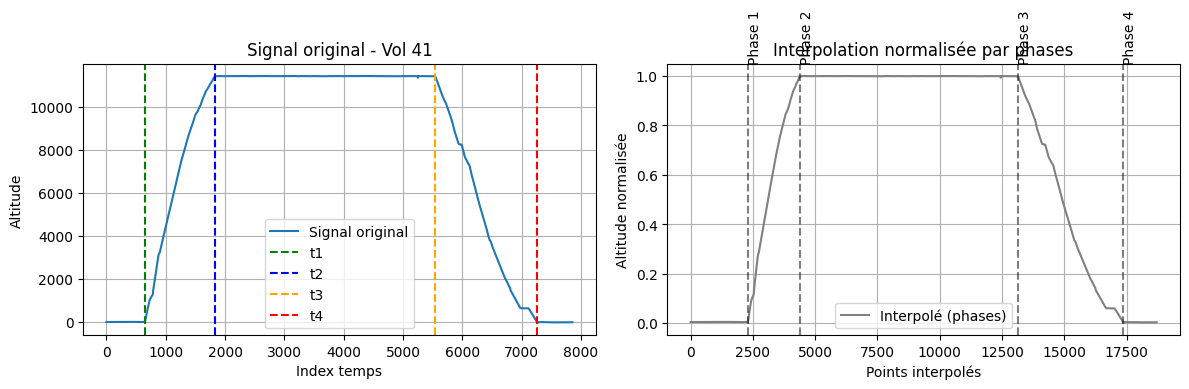

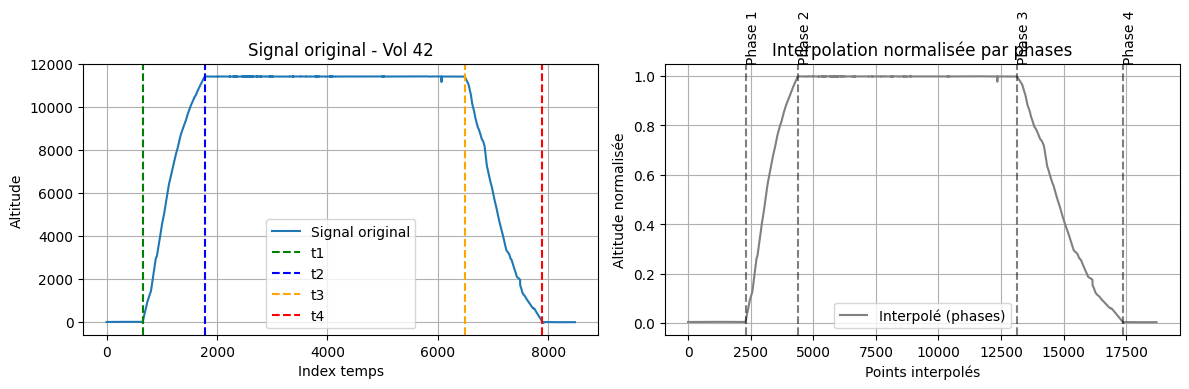

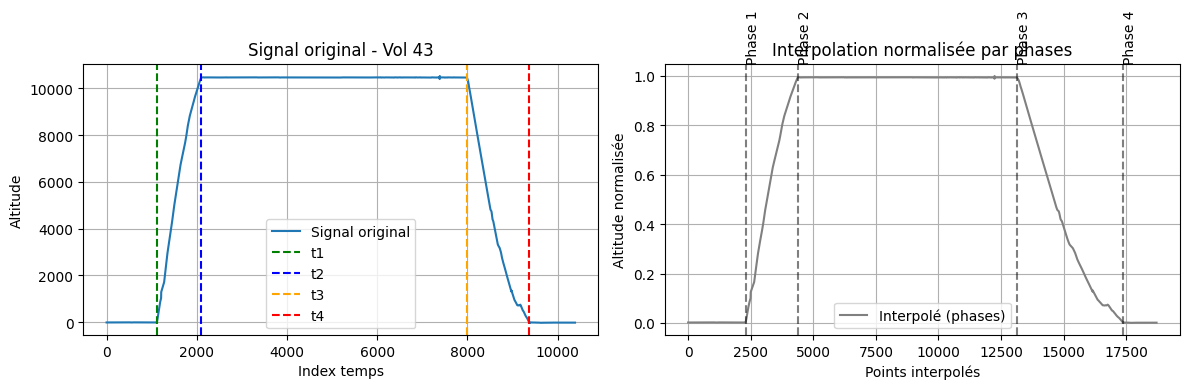

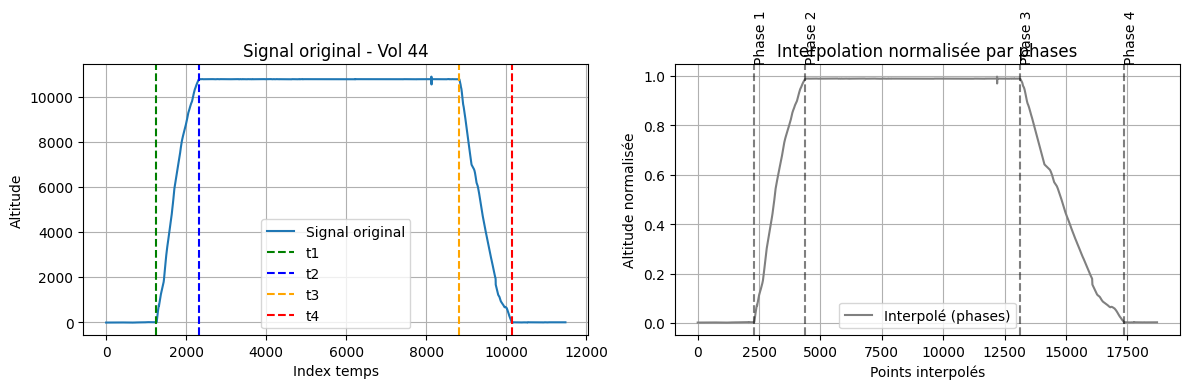

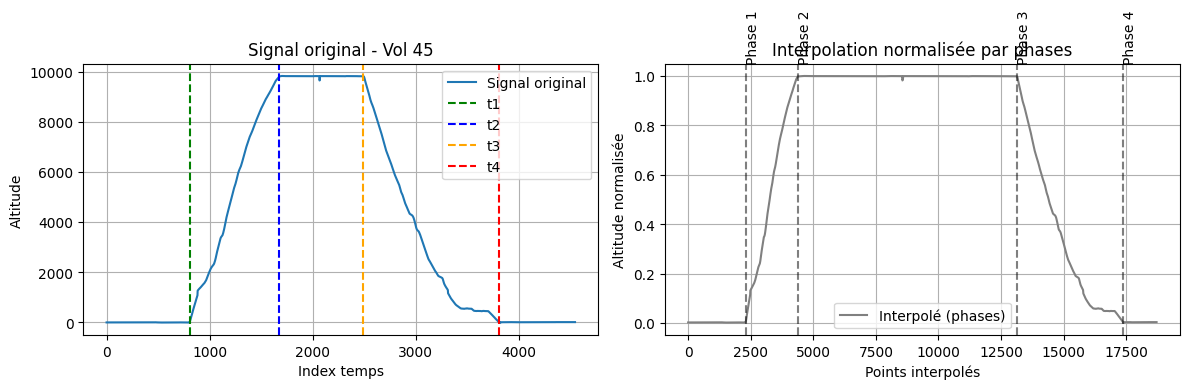

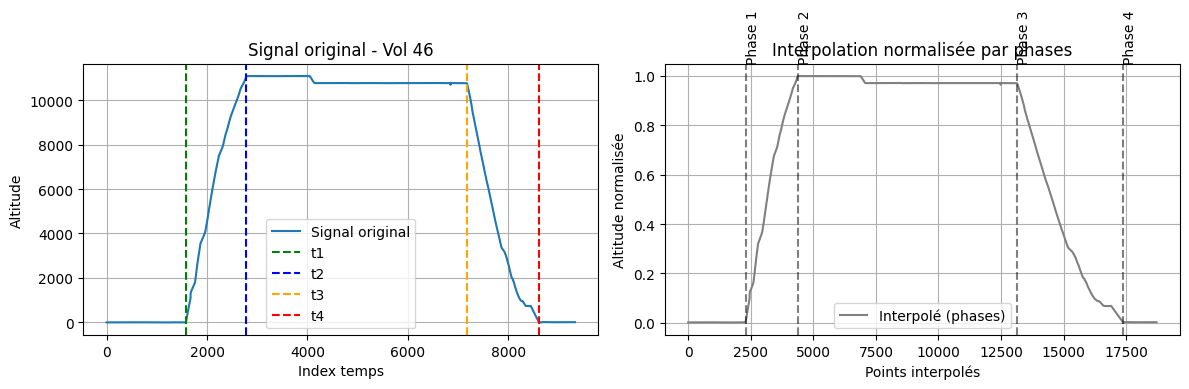

In [22]:
for record_index, df in enumerate(ds):
    # --- Données originales ---
    y = df['ALT[m]'].values
    index = df.index
    t1, t2, t3, t4 = compute_points(df)
    bounds = [0, t1, t2, t3, t4, len(df)-1]
    
    # --- Interpolation ---
    yn = (y - np.min(y)) / (np.max(y) - np.min(y))  # normalisation
    y_interp = []

    for i in range(len(bounds) - 1):
        i0, i1 = bounds[i], bounds[i+1]
        t0 = index[i0].value
        t1_ = index[i1].value
        t_new = pd.to_datetime(np.linspace(t0, t1_, NL[i]))
        y_new = np.interp(t_new, index[i0:i1], yn[i0:i1])
        y_interp.extend(y_new if i == 0 else y_new[1:])  # éviter doublons

    # --- Affichage ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 1. Courbe originale
    axes[0].plot(y, label='Signal original')
    axes[0].axvline(x=t1, color='g', linestyle='--', label='t1')
    axes[0].axvline(x=t2, color='b', linestyle='--', label='t2')
    axes[0].axvline(x=t3, color='orange', linestyle='--', label='t3')
    axes[0].axvline(x=t4, color='r', linestyle='--', label='t4')
    axes[0].set_title(f"Signal original - Vol {record_index}")
    axes[0].set_xlabel("Index temps")
    axes[0].set_ylabel("Altitude")
    axes[0].legend()
    axes[0].grid()

    # 2. Interpolation
    axes[1].plot(y_interp, color='gray', label="Interpolé (phases)")
    cum_lengths = np.cumsum(NL)
    for i, x in enumerate(cum_lengths[:-1]):
        axes[1].axvline(x=x, linestyle='--', color='k', alpha=0.5)
        axes[1].text(x, 1.05, f"Phase {i+1}", rotation=90, verticalalignment='bottom')
    axes[1].set_title("Interpolation normalisée par phases")
    axes[1].set_xlabel("Points interpolés")
    axes[1].set_ylabel("Altitude normalisée")
    axes[1].legend()
    axes[1].grid()

    fig.tight_layout()
    plt.show()
